Original features: 79, After Variance Threshold: 70, After PCA: 40
Epoch 1/100
625/625 [==============================] - 3s 4ms/step - loss: 0.6692 - mae: 0.5663 - val_loss: 0.5777 - val_mae: 0.5254
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.6239 - mae: 0.5445 - val_loss: 0.5595 - val_mae: 0.5169
Epoch 3/100
625/625 [==============================] - 2s 4ms/step - loss: 0.6053 - mae: 0.5363 - val_loss: 0.5449 - val_mae: 0.5113
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5901 - mae: 0.5326 - val_loss: 0.5242 - val_mae: 0.5029
Epoch 5/100
625/625 [==============================] - 2s 2ms/step - loss: 0.5705 - mae: 0.5264 - val_loss: 0.5125 - val_mae: 0.4988
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.5551 - mae: 0.5217 - val_loss: 0.4929 - val_mae: 0.4908
Epoch 7/100
625/625 [==============================] - 2s 3ms/step - loss: 0.5392 - mae: 0.5155 - val_loss: 0.4782 - val_mae: 0.4862
Ep

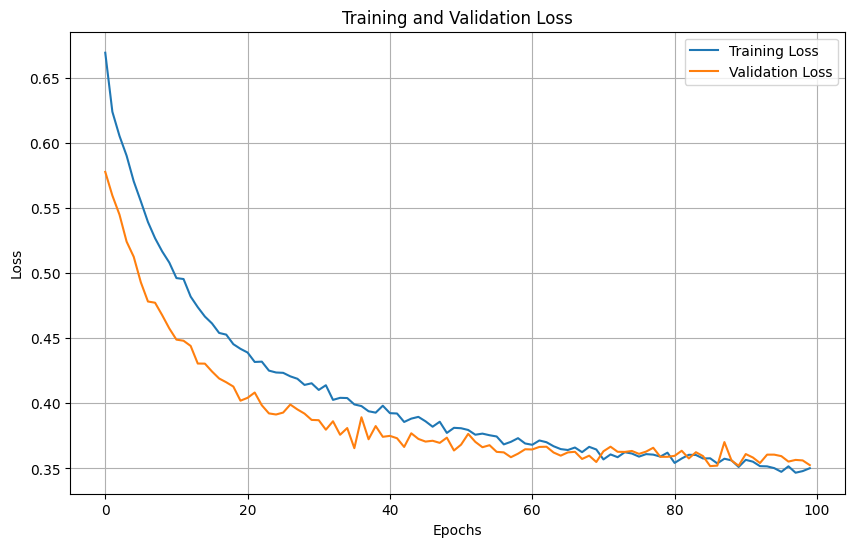

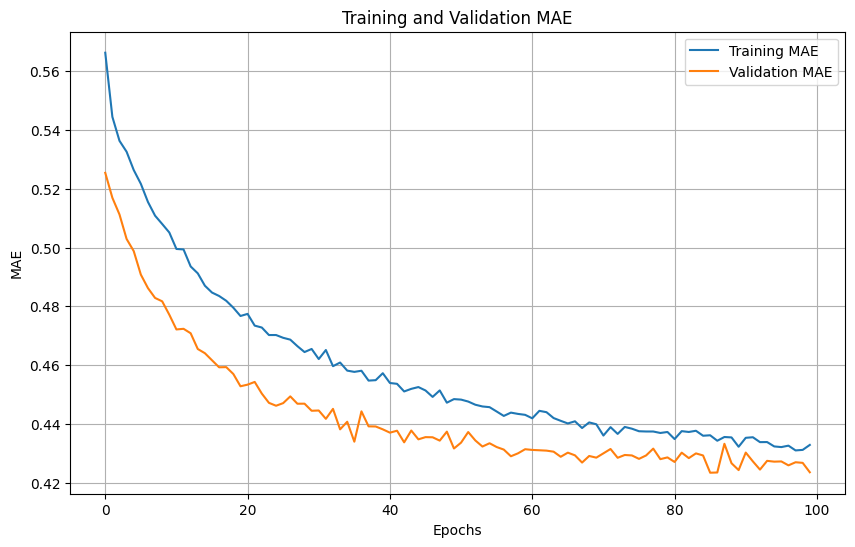

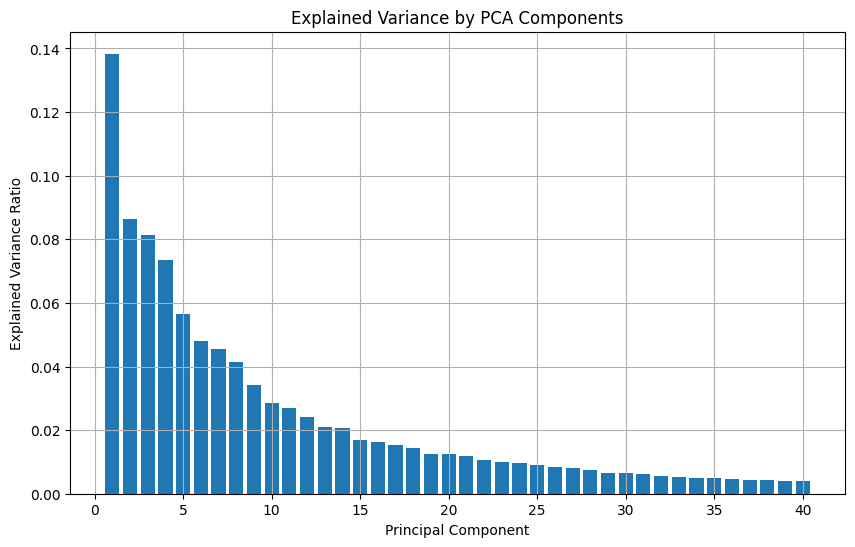

In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# ------------------------------
# 1. Feature Engineering
# ------------------------------

# Load data
data_dir = "/Users/abdur-rahmanibn-bilalwaajid/jane_street_project/data/train.parquet"
features_file = "/Users/abdur-rahmanibn-bilalwaajid/jane_street_project/data/features.csv"

# Step 1: Load features.csv to identify all features
features_df = pd.read_csv(features_file)
all_features = features_df["feature"].tolist()

# Include target column and load data for a manageable partition
selected_features = all_features + ["responder_6"]
df = pd.read_parquet(f"{data_dir}/partition_id=0", engine="pyarrow", columns=selected_features).head(50000)

# Step 2: Handle missing values
df.fillna(0, inplace=True)  # Replace NaN values with 0

# Step 3: Feature Variance Threshold (remove low-variance features)
X = df.drop(columns=["responder_6"]).values
y = df["responder_6"].values

# Remove low-variance features
variance_threshold = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
X_high_variance = variance_threshold.fit_transform(X)

# Step 4: Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_high_variance)

# Step 5: Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X.shape[1]}, After Variance Threshold: {X_high_variance.shape[1]}, After PCA: {X_pca.shape[1]}")

# ------------------------------
# 2. Train/Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# ------------------------------
# 3. Define MLP Model
# ------------------------------

# Improved MLP architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# ------------------------------
# 4. Train the Model
# ------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # Increase epochs as needed
    batch_size=64,  # Adjust batch size based on available memory
    verbose=1
)

# ------------------------------
# 5. Evaluate the Model
# ------------------------------
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# ------------------------------
# 6. Visualization
# ------------------------------

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

# Plot PCA explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.title('Explained Variance by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()